
# Classification de bouteilles en verre et plastique


Étudiant - Jonathan TABET
Entreprise BEELDI
Date : 2019/12/06

## Plan
* Première partie : Importation et traitements des images
* Deuxième partie : Extractions des primitives
* Troisième partie : Création d'un arbre de décision


In [28]:
import cv2
import pylab
import csv
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import pandas as pd
from skimage import io
from skimage.color import rgb2hsv

In [29]:
def readImages(dir,file):
    """
    Read images in the directory and id and labels of these images in file, 
    return a list of images and an array of class and id of these images. 
    Args:
        dir (str): The directory where the images are stocked.
        file (str): The file where the id and class are stocked.

    Returns:
        images[] (list) : a list of images
        Y['id','class'] (np.array) : an array of the corresponding id and class  
    """

    plastic_array = []
    glass_array = []
    with open(file, 'r') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        next(csv_reader) # skip header
        data = [r for r in csv_reader] # for all rows, add in data
        plastic_count = 0
        glass_count = 0
        c = 0
        for row in data:
            path = dir + row['id'] + ".jpg"
            if(os.path.exists(path) and (plastic_count + glass_count) < 100):
                if row['class'] == 'plastic' and plastic_count < 50: 
                    plastic_array.append(row)
                    plastic_count += 1
                elif row['class'] == 'glass' and glass_count < 50:
                    glass_array.append(row)   #else append to the smooth's list
                    glass_count += 1
    # Generate X and Y matrices
    Y = plastic_array + glass_array
    Y = np.array(Y)
    images = []
    for row in Y:
        images.append(io.imread(dir + row["id"] + '.jpg'))

    X = np.array(images)
    print("Images lues")
    return images, Y

In [30]:
def imgToGray(image):
    """
    Turn an image into shades of gray

    Args: 
        image : an OpenCV standard image format.
        

    Returns:
        img_gray_float : an OpenCV gray image.
         
    """
    img_gray = cv2.cvtColor(image.astype("uint8"), cv2.COLOR_BGR2GRAY)
    img_gray_float = img_gray.astype(np.float32)
    return img_gray_float

In [31]:
def rescale(image, min=0, max=255):
        """ Rescale the colors of an image.
        Utility method to rescale colors from an image. 
        Args: 
            image: an OpenCV standard image format.
            min: The minimum color value [0, 255] range.
            max: The maximum color value [0, 255] range.
        
        Returns:
            The image with rescaled colors.
        """
        image = image.astype('float')
        image -= image.min()
        image /= image.max()
        image = image * (max - min) + min

        return image

In [32]:
def saturate(image, q0=0.01, q1=0.75):
        """ Stretch contrasts of an image. 
        
        Utility method to saturate the contrast of an image. 

        Args:
            image: an OpenCV standard image format.
            q0: minimum coefficient.
            q1: maximum coefficient.

        Returns:
            The image with saturated contrasts. 
        """
        assert image is not None
        
        if q0 is None:
            q0 = 0
        if q1 is None:
            q1 = 1
        q = np.quantile(image[np.nonzero(image)].flatten(), [q0, q1])
        image[image < q[0]] = q[0]
        image[image > q[1]] = q[1]
        
        return image

In [33]:
def remove_starlight(image_color, image_gray):
        """ Removes the star light in images.

        Calclates the median in color and gray scale image to clean the image's background.

        Args:
             image_color: an OpenCV standard color image format.
             image_gray: an OpenCV standard gray scale image format.

        Returns:
            An image cleaned from star light.
        """
        t = np.max(np.median(image_color[np.nonzero(image_gray)]))
        image_color[image_color < t] = t

        return rescale(image_color).astype("uint8")


In [34]:
def imageBlur(image):
    """ Blur the image.

        Uses Gaussian and Median blur.

        Args:
             image : an OpenCV standard image format.

        Returns:
            img_blurred : an image blurred.
        """
    img_blurred = cv2.GaussianBlur(image, (3,3), 0)
    img_blurred = cv2.medianBlur(img_blurred, 5)
    return img_blurred

In [35]:
def imageCrop(image,l):
    """ Crop the image of l pixels.

        Args:
             image : an OpenCV standard image format.
             l : an integer.

        Returns:
            An image croped.
    """
    center_x = image.shape[1]//2       #Find center x position of the image
    center_y = image.shape[0]//2       #Find center y position of the image
    return image[center_y - l:center_y + l, center_x - l:center_x + l,:]

In [36]:
def PipelineColor(image):
    """
    From an image in format 100*100, return the hue of the center pixel

        Args:
             image : an OpenCV standard image format.

        Returns:
            nombre (float) : the value of the hue of the center pixel
        """
    img_color_float = image.astype(np.float32)
    img_blurred = imageBlur(img_color_float)
    img_gray_float = imgToGray(image)
    img_color = remove_starlight(image_color=img_blurred, image_gray=img_gray_float)
    img_finale = imageCrop(img_color,100)
    nombre = rgb2hsv(np.array([[img_finale[50][50]]]))[0][0][0]
    return nombre

In [37]:
def PipelineShape(image):
    """ Return shape of an image.
        
        From an Image, find the dominant shape on it. Return the ratio width/length.
        If there is no shape found return 0.
        If length = 0 return 1.

        Args:
             image : an OpenCV standard image format..

        Returns:
            nombre (float): he ratio width/length of the biggest shape on the image
    """
    img_color_float = image.astype(np.float32)
    img_blurred = imageBlur(img_color_float)
    img_gray_float = imgToGray(image)
    img_color = remove_starlight(image_color=img_blurred, image_gray=img_gray_float)
    saturated = saturate(image=img_color, q0=0.1, q1=0.85)
    image_crop = imageCrop(saturated,50)
    
    img_gray = cv2.cvtColor(image_crop,cv2.COLOR_BGR2GRAY) #filtrage de l'image pour ameliorer l'ellipse crée
    ret, thresh = cv2.threshold(img_gray, 11, 255,0)
    contours,hierarchy = cv2.findContours(thresh,2,1)
    if len(contours)>0:
        cnt = contours[0]
        if len(cnt)>5:
            ellipse = cv2.fitEllipse(cnt) #creation d'une ellipse autour de l'objet detecté
            img_ellipse = cv2.ellipse(img_gray,ellipse,(0,255,0),2)

            leftmost = tuple(cnt[cnt[:,:,0].argmin()][0]) #point de l'ellipse le plus à gauche
            rightmost = tuple(cnt[cnt[:,:,0].argmax()][0])#point de l'ellipse le plus à droite
            topmost = tuple(cnt[cnt[:,:,1].argmin()][0])# point de l'ellipse le plus en haut
            bottommost = tuple(cnt[cnt[:,:,1].argmax()][0])# point de l'ellipse le plus en bas

            a=(((rightmost[0]-leftmost[0])**2)+((rightmost[1]-leftmost[1])**2))**(1/2) #calcul de la largeur de l'ellipse
            b=(((topmost[0]-bottommost[0])**2)+((topmost[1]-bottommost[1])**2))**(1/2) #calcul de la longueur de l'ellipse
            if b == 0 :
                c = 1
            else :
                c = a/b #creation largeur sur longueur
        else :
            c = 0
    else : 
        c = 0
    return c

In [38]:
def PipelineEntropy(image): 
    """ Extract entropy from an image

        Args:
             image : an OpenCV standard image format.

        Returns:
            the entropy of the image
    """
    # https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=calchist#calchist
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Shannon entropy formula
    hist = hist.ravel() / hist.sum()
    logs = np.nan_to_num(np.log2(hist))
    return -1 * (hist * logs).sum()

In [39]:
X, Y = readImages('dataset-resized\\','Bottles.csv')


Images lues


In [40]:
X_color = [PipelineColor(image) for image in X]

In [41]:
X_shape = [PipelineShape(image) for image in X]

In [42]:
X_entropy = [PipelineEntropy(image) for image in X]

C:\Users\Jonathan Tabet\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log2
  


Text(0.5, 0.98, 'Valeurs du pixel central')

<Figure size 432x288 with 0 Axes>

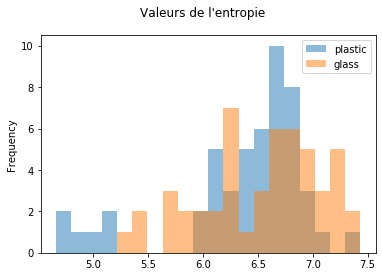

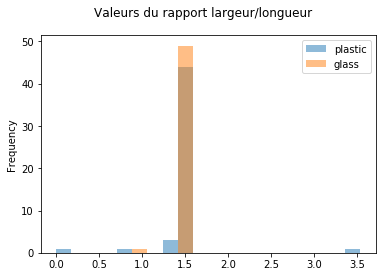

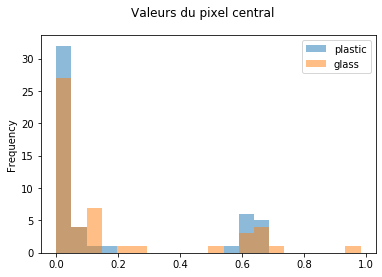

In [43]:
df_enthropy = pd.DataFrame(list(zip(X_entropy[:50], X_entropy[50:])), 
               columns =['plastic', 'glass']) 
df_shape = pd.DataFrame(list(zip(X_shape[:50], X_shape[50:])), 
               columns =['plastic', 'glass']) 
df_color = pd.DataFrame(list(zip(X_color[:50], X_color[50:])), 
               columns =['plastic', 'glass']) 

plt.figure();
df_enthropy.plot.hist(alpha=0.5,bins=20)
pylab.suptitle("Valeurs de l'entropie")
df_shape.plot.hist(alpha=0.5,bins=20)
pylab.suptitle("Valeurs du rapport largeur/longueur")
df_color.plot.hist(alpha=0.5,bins=20)
pylab.suptitle("Valeurs du pixel central")

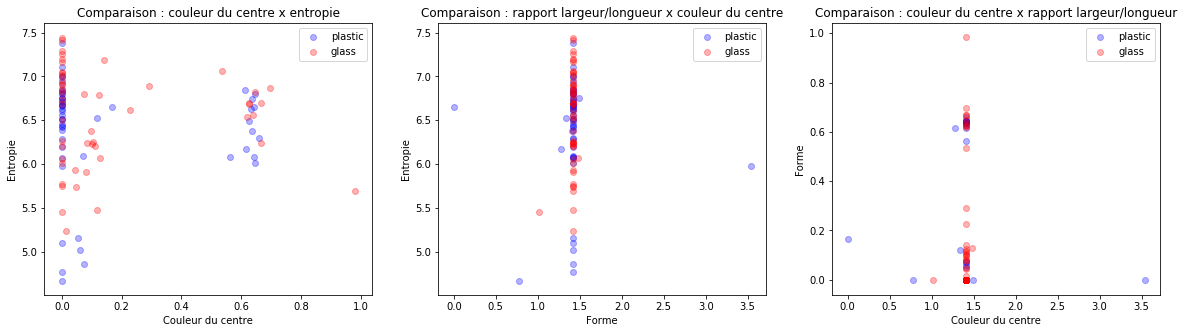

In [44]:
fig, ax = plt.subplots(1,3,figsize=(20, 5))
ax[0].scatter(X_color[:50], X_entropy[:50], c = 'b',label='plastic', alpha = 0.3)
ax[0].scatter(X_color[50:], X_entropy[50:], c = 'r',label='glass', alpha = 0.3)
ax[0].set_title("Comparaison : couleur du centre x entropie")
ax[0].set(xlabel = 'Couleur du centre', ylabel='Entropie')

ax[1].scatter(X_shape[:50], X_entropy[:50], c = 'b',label='plastic', alpha = 0.3)
ax[1].scatter(X_shape[50:], X_entropy[50:], c = 'r',label='glass', alpha = 0.3)
ax[1].set_title("Comparaison : rapport largeur/longueur x couleur du centre")
ax[1].set(xlabel = 'Forme', ylabel='Entropie')

ax[2].scatter(X_shape[:50],X_color[:50], c = 'b',label='plastic', alpha = 0.3)
ax[2].scatter(X_shape[50:],X_color[50:], c = 'r',label='glass', alpha = 0.3)
ax[2].set_title("Comparaison : couleur du centre x rapport largeur/longueur")
ax[2].set(xlabel = 'Couleur du centre', ylabel='Forme')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.show()

In [45]:
X_features = [0]*len(X)
for k in range(len(X)):
    X_features[k] = [X_entropy[k],X_color[k],X_shape[k]]
Y_verif = ['plastic']*50+['glass']*50 

X_features_training =  X_features[0:35]+X_features[50:85]
Y_training = ['plastic']*35+['glass']*35

X_features_test =  X_features[35:50]+X_features[85:]
Y_test = ['plastic']*15+['glass']*15


In [46]:
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
DEPTHS = [None, 2, 3, 4, 5, 10]
Scores = []
for depth in DEPTHS:
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf = clf.fit(X_features_training, Y_training)
    score = clf.score(X_features_test, Y_test)
    Scores.append(score)
    
    print(" - Score et cross validation score : " + str(depth) + " depth - ")
    print(score)
    print(cross_val_score(clf, X_features, Y_verif, cv=5))

 - Score et cross validation score : None depth - 
0.6
[0.5  0.75 0.65 0.6  0.6 ]
 - Score et cross validation score : 2 depth - 
0.5
[0.45 0.55 0.5  0.45 0.4 ]
 - Score et cross validation score : 3 depth - 
0.43333333333333335
[0.6  0.75 0.5  0.45 0.4 ]
 - Score et cross validation score : 4 depth - 
0.6
[0.45 0.8  0.6  0.4  0.75]
 - Score et cross validation score : 5 depth - 
0.6
[0.75 0.85 0.6  0.5  0.4 ]
 - Score et cross validation score : 10 depth - 
0.6
[0.65 0.75 0.75 0.6  0.6 ]


Text(0, 0.5, 'Précision')

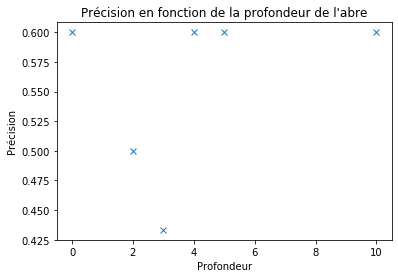

In [47]:
plt.plot([0, 2, 3, 4, 5, 10],Scores,'x')
plt.title("Précision en fonction de la profondeur de l'abre")
plt.xlabel("Profondeur")
plt.ylabel("Précision")

[Text(83.7, 195.696, 'X[0] <= 5.195\nentropy = 0.5\nsamples = 70\nvalue = [35, 35]'),
 Text(41.85, 152.208, 'entropy = 0.0\nsamples = 6\nvalue = [0, 6]'),
 Text(125.55000000000001, 152.208, 'X[0] <= 5.96\nentropy = 0.496\nsamples = 64\nvalue = [35, 29]'),
 Text(83.7, 108.72, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]'),
 Text(167.4, 108.72, 'X[1] <= 0.085\nentropy = 0.499\nsamples = 55\nvalue = [26, 29]'),
 Text(83.7, 65.232, 'X[0] <= 7.03\nentropy = 0.444\nsamples = 30\nvalue = [10, 20]'),
 Text(41.85, 21.744, 'entropy = 0.393\nsamples = 26\nvalue = [7, 19]'),
 Text(125.55000000000001, 21.744, 'entropy = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(251.10000000000002, 65.232, 'X[2] <= 1.414\nentropy = 0.461\nsamples = 25\nvalue = [16, 9]'),
 Text(209.25, 21.744, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(292.95, 21.744, 'entropy = 0.397\nsamples = 22\nvalue = [16, 6]')]

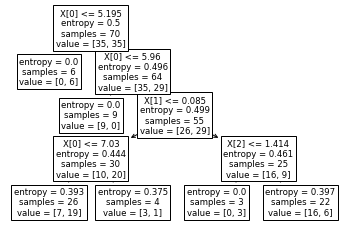

In [48]:
clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(X_features_training, Y_training)
tree.plot_tree(clf)